In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define class routine

In [2]:
from numbers import Integral
import numpy as np


class System(object):
    def __init__(self, dim):
        assert isinstance(dim, Integral) and dim >= 0
        self.dim = dim
        
        
class PointChargeSystem(System):
    
    def __init__(self, dim, coords, charges):
        super().__init__(dim)
        _coords, _charges = (self._try2arr(arg) for arg in (coords, charges))
        assert _coords.ndim == 2 and _charges.ndim == 1
        if _coords.shape[0] == _charges.size: self.N = _charges.size
        else: raise Exception("mismatch of numbers of chrages and coordinates")
        self.coords, self.charges = _coords, _charges
        
        
    @staticmethod
    def _try2arr(arr):
        if isinstance(arr, np.ndarray): return arr
        try: _ndarr = np.array(arr)
        except: raise TypeError("Could not convert arguments to {}".format(np.ndarray))
        return _ndarr

    
    def V_and_E(self, coords, thres=1e-10):
        """Evaluates electric potential in atomic units
        
        # Arguments
        - `coords` ndarray of shape (dim,...)
          : coordinates of evaluation
        """
        _coords_original = self._try2arr(coords)
        
#         print(coords, _coords_original)
        
        assert _coords_original.shape[0] == self.dim
        _coords = np.moveaxis(_coords_original, 0, -1)
        
        _V = np.zeros(_coords.shape[:-1], dtype=float)
        _E = np.zeros(_coords_original.shape, dtype=float)
        for _ri, _qi in zip(self.coords, self.charges):
            _rel_coords = _coords - _ri
            _dist_sq = np.square(_rel_coords).sum(axis=-1)
            _dist = np.array(np.sqrt(_dist_sq))
            _dist[_dist<thres] = thres
            
            _Vi = _qi / _dist
            _V += _Vi
            
            _Ei = (_Vi / _dist_sq) * np.moveaxis(_rel_coords, -1, 0)
            _E += _Ei
            
        return _V, _E
    
    
    def V(self, coords, thres=1e-10):
        _V, _ = self.V_and_E(coords, thres)
        return _V
    
    
    def E(self, coords, thres=1e-10):
        _, _E = self.V_and_E(coords, thres)
        return _E

# Construct a system of point charges

In [3]:
charge_coords = ([-1,1,0],[1,0,0],[-1,-1,0])
charges = (-1, 2, -1)
sys = PointChargeSystem(3, charge_coords, charges)

### Test evaluation of potential and electric field

In [4]:
sys.V_and_E(((4,5),(1,3),(0,0)))

(array([0.24676019, 0.10321107]), array([[0.11772022, 0.02428195],
        [0.05043898, 0.02942699],
        [0.        , 0.        ]]))

In [5]:
sys.V_and_E((4,0,0))

(array(0.2744344), array([0.14679294, 0.        , 0.        ]))

# Evaluate electric field line

### The field line integration is stopped at one of the following cases:
- went close enough to any of the negative charges
- went out of bounding box

In [6]:
positive_charge_indice, = np.where(sys.charges > 0)
delta = 0.01
N_per_charge = 8
N_posi_charge = len(positive_charge_indice)
N_lines = N_per_charge * N_posi_charge

# r0_arr = np.empty((N_lines, sys.dim), dtype=float)
r0_list = []
for charge_ind in positive_charge_indice:
    ri = sys.coords[charge_ind]
    for i in range(N_per_charge):
        angle = 2*np.pi * i / N_per_charge
        disp = np.array((delta*np.cos(angle), delta*np.sin(angle), 0))
        r0_list.append(ri + disp)
r0_arr = np.array(r0_list)

assert r0_arr.shape == (N_lines, sys.dim)

In [7]:
from scipy.integrate import ode

ode_E_func = lambda t, x: sys.E(x)
r = ode(ode_E_func).set_integrator('dopri5')

field_lines = []

t0, tmax = 0.0, 1.0
for r0 in r0_arr:
    r.set_initial_value(r0, t0)

    sol = []
    solout = lambda t, y: sol.append([t, *y])
    r.set_solout(solout)
    r.integrate(tmax)

    sol_arr = np.array(sol)
    field_lines.append(sol_arr)

/home/seongjin/py/venv/sci/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


# Plot $V\left(\mathbf{r}\right)$ and $\mathbf{E}$

### Prepare evalulation coordnates

In [8]:
mesh_x_val = np.linspace(-3,3,51)
mesh_y_val = np.linspace(-3,3,31)
X, Y = np.meshgrid(mesh_x_val, mesh_y_val)
Z = np.zeros_like(X)

### Evaluate $V(\mathbf{r})$

In [9]:
V_arr = sys.V((X, Y, Z))

### Configure plot appearence

In [10]:
# Configure colormap
vmax = np.abs(np.quantile(V_arr, (0.005,0.995))).max()
vmin = -vmax
from matplotlib.colors import Normalize
norm = Normalize(vmin, vmax)

# Configure display extent
xlim = mesh_x_val[[0, -1]]
ylim = mesh_y_val[[0, -1]]
extent = (*xlim, *ylim)

# Configure contour lines
levels = np.quantile(V_arr, np.linspace(0.05, 0.95, 7))

### Actual plotting

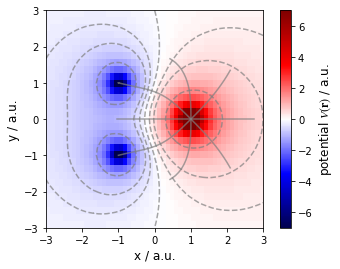

In [11]:
fig, ax = plt.subplots()

img = ax.imshow(V_arr, norm=norm, cmap='seismic', extent=extent, origin='lower')

ax.contour(X, Y, V_arr, levels, colors='gray', linestyles='dashed', alpha=0.7)

for field_line in field_lines:
    ax.plot(field_line[:,1], field_line[:,2], color='gray', alpha=0.7)

ax.set_xlabel("x / a.u."), ax.set_ylabel("y / a.u.")
cb = fig.colorbar(img, ax=ax)
cb.set_label(r"potential $V\left(\mathbf{r}\right)$ / a.u.")

In [13]:
# fig.savefig("potential-with-field-test-2.png")